# Convolutional Neural Networks

## Image Classification With Feedforward Neural Networks
In the previous lecture we have seen a simple feedforward neural network. In this architecture the input is a vector in $R^d$ and each layer transforms the input applying an affine transformation and an nonlinearity applied elementwise. This approach can be in principle used also for images: assume I've a image represented as a tensor with shape $(H,W,3)$, I can flatten the image into a tensor with a single dimension $d = H\times W\times 3$ and use a feedforward neural network.
For example we can use a feedforward neural network to classify the handwritten digits in the MNIST dataset:

In [11]:
import torch
import torchvision
from torch.utils.data import DataLoader
from typing import Callable
import torch.nn as nn
import os
import matplotlib.pyplot as plt
import numpy as np

First we implement the training loop that will be used both for feedforward and convolutional neural networks.

In [12]:
def train_classifier(
        net:torch.nn.Module,
        opt:torch.optim.Optimizer,
        trainloader:DataLoader,
        valloader:DataLoader,
        criterion:Callable,
        epochs:int,
        print_every=10,
        model_name="net",
        save_path="./tmp/"):
    
    train_loss = []
    val_loss = []
    for epoch in range(epochs):

        # Train
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()

            # zero the parameter gradients
            opt.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            opt.step()

            # print statistics
            running_loss += loss.item()
            if i % print_every == (print_every-1):
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (i+1):.3f}')
        
        train_loss.append(running_loss/(i+1))
        
        # Validate
        running_loss = 0.0
        for i, data in enumerate(valloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()
            outputs = net(inputs)
            running_loss += criterion(outputs, labels).item()
        val_loss.append(running_loss/(i+1))

        # Save
        if len(val_loss)==1 or val_loss[-1] < val_loss[-2]:
            print("Validation Loss decreased, Saving")
            torch.save(net.state_dict(), os.path.join(save_path,f"{model_name}.pth"))

    return train_loss,val_loss

In [13]:
# helper function to count the parameters of the model
def count_parameters(model): 
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

And a function that computes the accuracy of the trained models.

In [14]:
def validate_classifier(
        net:torch.nn.Module,
        data:DataLoader):
        running_acc = 0
        for i, x in enumerate(data, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = x
            inputs = inputs.cuda()
            labels = labels.cuda()
            preds = net(inputs)
            labels = torch.argmax(labels,dim=-1,keepdim=False)
            preds = torch.argmax(preds,dim=-1,keepdim=False)
            running_acc += torch.sum(preds==labels)/labels.shape[0]
        return running_acc / (i+1)

Then we download the dataset, the MNIST dataset is available in `torchvision.datasets`.

In [15]:
def one_hot(l:int,num_cat = 10):
    t = torch.zeros((num_cat),dtype=torch.float32)
    t[l-1] = 1.
    return t
train = torchvision.datasets.FashionMNIST(
    "./tmp/FashionMNIST/",
    train=True, 
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(lambda x:torch.flatten(x))
    ]),
    target_transform=torchvision.transforms.Compose([
        torchvision.transforms.Lambda(one_hot)
    ]),
    download=True)

val = torchvision.datasets.FashionMNIST(
    "./tmp/FashionMNIST/",
    train=False, 
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(lambda x:torch.flatten(x))
    ]),
    target_transform=torchvision.transforms.Compose([
        torchvision.transforms.Lambda(one_hot)
    ]),
    download=True)

We instantiate the FeedForward Model.

In [16]:
from typing import Any


class FeedForward(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.l1 = nn.Linear(in_features=784,out_features=128)
        self.l2 = nn.Linear(in_features=128,out_features=32)
        self.l3 = nn.Linear(in_features=32,out_features=10)

    def __call__(self,x) -> Any:
        o = self.l1(x)
        o = torch.relu(o)
        o = self.l2(o)
        o = torch.relu(o)
        o = self.l3(o)
        return o

If the saved model is not found, then train the model:

In [17]:
MODEL_NAME="FeedForward"
EP = 10
BS = 128
LR=10**-2

train_loader = DataLoader(train,batch_size=BS)
val_loader = DataLoader(val,batch_size=BS)
net = FeedForward().cuda()
opt = torch.optim.SGD(net.parameters(),LR)
criterion = torch.nn.CrossEntropyLoss()
train_loss,val_loss= (None,None)
if not os.path.exists(f"./tmp/{MODEL_NAME}.pth"):
    print("training")
    train_loss,val_loss = train_classifier(
        net,
        opt,
        train_loader,
        val_loader,
        criterion,
        EP,
        model_name=MODEL_NAME
    )

Then we load the model with the best validation loss.

In [18]:
net.load_state_dict(torch.load(f"./tmp/{MODEL_NAME}.pth"))

<All keys matched successfully>

In [19]:
if train_loss and val_loss:
    plt.plot(train_loss,label="train loss")
    plt.plot(val_loss,label="val loss")
    plt.legend()
    plt.show()

In [20]:
acc = validate_classifier(net,val_loader)
print(f"Accuracy   : {acc}")
print(f"Num Params : {count_parameters(net)}")

Accuracy   : 0.8138844966888428
Num Params : 104938


## Convolution
The problem with Feedforward neural network is that, by flattening the input tensor into a tensor with a single dimension, we are ignoring the __structure__ of the input. In particular we know that the first two dimensions are height and width, while the third dimension refers to the channels (for black and white images we have a single channel, while for RGB images we have three channels). The idea behind convolution (in neural networks) is that I can do much better with fewer parameters by applying the same function on portions of the image. For example assume I want to extract edges, this is a local operation, meaning that I do not need to look at the entire image. In particular I use a linear function, that consists in sliding a kernel over the image and at each position compute the sum of the element-wise products (the mathematical term for this function is cross-correlation). Let $I\in \mathbb{R}^{n\times m}$ be the input image (with just one channel) and $K \in \mathbb{R}^{h\times k}$ the kernel, the result of the convolution is the feature map $O \in \mathbb{R}^{n' \times m'}$ obtained as:
$$
O[i,j] = \sum_h \sum_k I(i+h,j+k) K(h,k)
$$
This operation is illustrated by the following figure:
<p align="center">
  <img src="../imgs/no_padding_no_strides.gif" width=10%>
</p>

For example we can use the following kernels to extract vertical:
$$
K_v = \begin{pmatrix} 
    -1 & 0 & 1 \\
    -2 & 0 & 2 \\
    -1 & 0 & 1 \\
\end{pmatrix}
$$ 
and horizontal edges:
$$
K_h = \begin{pmatrix}
1 & 2 & 1 \\
0 & 0 & 0\\
-1 & -2 & -1\\
\end{pmatrix}
$$
Now we take an image from the MNIST dataset and compute the output feature map for the two kernels. Convolution can be computed using the function `torch.nn.functional.conv2d(input, weight, bias=None, stride=1, padding=0, dilation=1, groups=1)` where the input is a tensor with shape `(batch,inp_features,H,W)` and weight is the kernel and it is a tensor with shape `(inp_features,out_features,h,w)` (for the moment we ignore the other parameters). In this example the input has just one feature map (channel) and also the output has one feature map.

In [21]:
from PIL import Image
I = Image.open("../imgs/tiger.jpg").convert("L")
I = np.asanyarray(I)
I = I/255.0
I = I[None,None,...]
I = torch.tensor(I,dtype=torch.float32)

In [22]:
kv = torch.tensor(
    [[-1,0,1],
     [-2,0,2],
     [-1,0,1]],dtype=torch.float32)
kv = kv[None,None,...]

kh = torch.tensor(
    [[1,2,1],
     [0,0,0],
     [-1,-2,-1]],dtype=torch.float32)
kh = kh[None,None,...]


In [23]:
Ov = torch.nn.functional.conv2d(input=I,weight=kv)
Oh = torch.nn.functional.conv2d(input=I,weight=kh)
Ov.shape

torch.Size([1, 1, 366, 610])

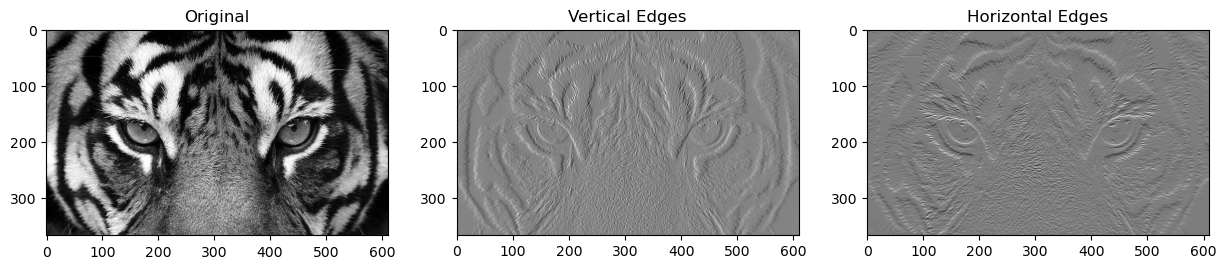

In [24]:
Ov = Ov[0,0,:,:,None]
Oh = Oh[0,0,:,:,None]
fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)
ax[0].imshow(I[0,0,:,:,None],cmap="gray")
ax[0].set_title("Original")
ax[1].imshow(Ov,cmap="gray")
ax[1].set_title("Vertical Edges")
ax[2].imshow(Oh,cmap="gray")
ax[2].set_title("Horizontal Edges")
plt.show()

## Convolutional Neural Network
A convolutional Neural Network stacks multiple convolutional layers, where the kernels are learned from data. If the input is a kernel with shape `(inp_features,H,W)` and we want an output with `out_features` feature maps, then the convolutional layer initializes `inp_features * out_features` kernels $k_i^j$ where the lower index is the index of the input feature and the upper index is the index of the output feature. Then the output feature map $O_l$ is obtained summing the input feature maps obtained through the kernels $K_i^l$:
$$
O_m[i,j] = \sum_l \sum_h \sum_k I(i+h,j+k) K_l^m(h,k)
$$
This procedure is illustrated by the following figure:
<p align="center">
  <img src="../imgs/conv.png" width=30%>
</p>

### Stride and Padding
Now we explain the meaning of the two parameters stride and padding. The stride determines how many cells the kernel is moved both in the horizontal and vertical direction. For stride different than 1, for example s in both directions, the equation becomes:
$$
O_m[i,j] = \sum_l \sum_h \sum_k I(i+sh,j+sk) K_l^m(h,k)
$$.
Padding specifies the number of zeros concatenated at the beginning and at the end of an axis, the most used options are `padding="valid"` that means no padding and `padding="same"` that adds a number of zeros such that the input and output images have the same shape.

### Pooling
Another ingredient that is necessary to build a convolutional neural network is the pooling layer. The most used are Max Pooling and Average Pooling. The first one returns the maximum value in a region of the image specified by the kernel size while the second the average. The stride and padding parameters are defined as in the case of convolutional layers. Pooling is used to reduce the size of the input summarizing the subregions. Usually the stride is equal to the kernel size, in order to avoid overlaps.

### Example
Now we train a simple convolutional neural network on the fashion mnist dataset and we compare the performances with the feed forward networks both in terms of accuracy and number of parameters.

In [25]:
train = torchvision.datasets.FashionMNIST(
    "./tmp/FashionMNIST/",
    train=True, 
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ]),
    target_transform=torchvision.transforms.Compose([
        torchvision.transforms.Lambda(one_hot)
    ]),
    download=True)

val = torchvision.datasets.FashionMNIST(
    "./tmp/FashionMNIST/",
    train=False, 
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ]),
    target_transform=torchvision.transforms.Compose([
        torchvision.transforms.Lambda(one_hot)
    ]),
    download=True)

To design a convolutional neural network it is useful to know the output size given the input size. If we denote with i the input size (of a square image), k the square kernel size, s the stride (same along both axis) and p the padding (same along both axis) then we can compute the size of the output in each different case (we will see only the most common):
- __p=0 (valid), s=1__, then $o = (i-k) + 1$
- __same padding s=1__, then $p = \lfloor \frac{k}{2} \rfloor$ and $o=i$

For the pooling layers the size of the output can be computed as:
$$
o = \lfloor \frac{i-k}{s} \rfloor + 1
$$

In [26]:
from typing import Any


class ConvNet(nn.Module):

    def __init__(self) -> None:
        super().__init__()
        # (1,28,28) -> (16,26,26)
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=16,kernel_size=(3,3),padding="valid",stride=1)
        # (16,26,26) -> (16,13,13)
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2),stride=2)
        # (16,13,13) -> (36,11,11)
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=36,kernel_size=(3,3),padding="valid",stride=1)
        # (36,11,11) -> (36,5,5)
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2),stride=2)
        # (36,5,5) -> (64,4,4)
        self.conv3 = nn.Conv2d(in_channels=36,out_channels=64,kernel_size=(2,2),stride=1)
        # (64,4,4) -> (64,1,1)
        self.pool3 = nn.MaxPool2d(kernel_size=(4,4),stride=2)
        # (64,1,1) -> (64)
        self.flatten = nn.Flatten()
        # (64) -> (10)
        self.classifier = nn.Linear(in_features=64,out_features=10)

    def __call__(self,x) -> Any:
        o = self.conv1(x)
        o = self.pool1(o)
        o = self.conv2(o)
        o = self.pool2(o)
        o = self.conv3(o)
        o = self.pool3(o)
        o = self.flatten(o)
        o = self.classifier(o)
        return o


In [27]:
MODEL_NAME="ConvNet"
EP = 10
BS = 128
LR=10**-2

train_loader = DataLoader(train,batch_size=BS)
val_loader = DataLoader(val,batch_size=BS)
net = ConvNet().cuda()
opt = torch.optim.SGD(net.parameters(),LR)
criterion = torch.nn.CrossEntropyLoss()
train_loss,val_loss= (None,None)
if not os.path.exists(f"./tmp/{MODEL_NAME}.pth"):
    print("training")
    train_loss,val_loss = train_classifier(
        net,
        opt,
        train_loader,
        val_loader,
        criterion,
        EP,
        model_name=MODEL_NAME
    )

training
[1,    10] loss: 2.304
[1,    20] loss: 2.305
[1,    30] loss: 2.304
[1,    40] loss: 2.303
[1,    50] loss: 2.302
[1,    60] loss: 2.302
[1,    70] loss: 2.301
[1,    80] loss: 2.301
[1,    90] loss: 2.300
[1,   100] loss: 2.300
[1,   110] loss: 2.299
[1,   120] loss: 2.299
[1,   130] loss: 2.298
[1,   140] loss: 2.298
[1,   150] loss: 2.297
[1,   160] loss: 2.296
[1,   170] loss: 2.296
[1,   180] loss: 2.295
[1,   190] loss: 2.294
[1,   200] loss: 2.294
[1,   210] loss: 2.293
[1,   220] loss: 2.293
[1,   230] loss: 2.292
[1,   240] loss: 2.291
[1,   250] loss: 2.290
[1,   260] loss: 2.290
[1,   270] loss: 2.289
[1,   280] loss: 2.288
[1,   290] loss: 2.287
[1,   300] loss: 2.286
[1,   310] loss: 2.286
[1,   320] loss: 2.285
[1,   330] loss: 2.284
[1,   340] loss: 2.283
[1,   350] loss: 2.282
[1,   360] loss: 2.281
[1,   370] loss: 2.279
[1,   380] loss: 2.278
[1,   390] loss: 2.277
[1,   400] loss: 2.276
[1,   410] loss: 2.274
[1,   420] loss: 2.273
[1,   430] loss: 2.271
[1

In [28]:
net.load_state_dict(torch.load(f"./tmp/{MODEL_NAME}.pth"))

<All keys matched successfully>

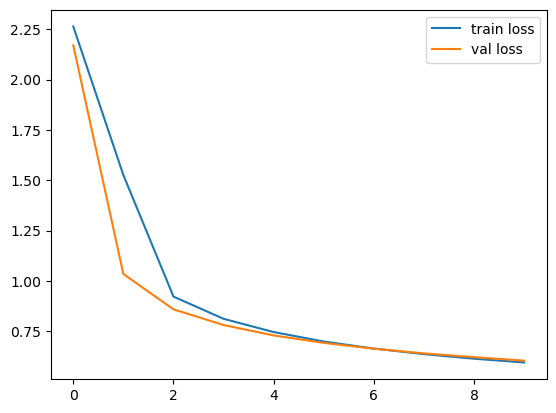

In [29]:
if train_loss and val_loss:
    plt.plot(train_loss,label="train loss")
    plt.plot(val_loss,label="val loss")
    plt.legend()
    plt.show()

In [30]:
acc = validate_classifier(net,val_loader)
print(f"Accuracy   : {acc}")
print(f"Num Params : {count_parameters(net)}")

Accuracy   : 0.7835245728492737
Num Params : 15310
